## Preprocessing 

In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
actions = ['cold', 'dizziness', 'allergic_reaction']
actions = np.array(actions)

In [3]:
label_map = {label:num for num, label in enumerate(actions)}

In [4]:
label_map

{'cold': 0, 'dizziness': 1, 'allergic_reaction': 2}

In [5]:
print(len([name for name in os.listdir(os.path.join('keypoints', 'allergic_reaction'))]))

100


In [6]:
sequences, labels = [], []
for action in actions:
    for sequence in range(100):
        window = []
        for frame_num in range(90):
            res = np.load(os.path.join('keypoints', action, str(sequence+1), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [7]:
np.array(sequences).shape

(300, 90, 1662)

In [8]:
np.array(labels).shape

(300,)

In [9]:
X = np.array(sequences)

In [10]:
X.shape

(300, 90, 1662)

In [11]:
y = to_categorical(labels).astype(int)

In [12]:
y.shape

(300, 3)

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))

In [14]:
X_scale = scaler.fit_transform(X.reshape(X.shape[0], -1)).reshape(X.shape)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2)

In [16]:
X_test.shape

(60, 90, 1662)

In [17]:
y_test.shape

(60, 3)

In [18]:
X_train[0]

array([[0.37805881, 0.29654889, 0.7664673 , ..., 0.        , 0.        ,
        1.        ],
       [0.37000045, 0.29862157, 0.54764157, ..., 0.        , 0.        ,
        1.        ],
       [0.36201766, 0.29332789, 0.58925324, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.38464829, 0.17215488, 0.79586028, ..., 0.        , 0.        ,
        0.96354887],
       [0.38462709, 0.17524074, 0.78938108, ..., 0.        , 0.        ,
        0.95612421],
       [0.38554632, 0.18049955, 0.78391125, ..., 0.        , 0.        ,
        0.94325545]])

## Build and Train LSTM Neural Network

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [20]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [21]:
model = Sequential()
model.add(LSTM(64, return_sequences=False, activation='relu', input_shape=(90, 1662)))
model.add(Dense(64, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001) , loss='categorical_crossentropy', metrics='categorical_accuracy')

In [23]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100


2022-12-02 08:15:06.000783: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


6/6 [==============================] - 1s 104ms/step - loss: 1.6596 - categorical_accuracy: 0.3698 - val_loss: 1.6142 - val_categorical_accuracy: 0.2500
Epoch 2/100
6/6 [==============================] - 0s 55ms/step - loss: 1.2127 - categorical_accuracy: 0.3333 - val_loss: 1.3706 - val_categorical_accuracy: 0.2500
Epoch 3/100
6/6 [==============================] - 0s 61ms/step - loss: 1.1463 - categorical_accuracy: 0.3438 - val_loss: 1.2790 - val_categorical_accuracy: 0.2917
Epoch 4/100
6/6 [==============================] - 0s 52ms/step - loss: 1.1142 - categorical_accuracy: 0.3906 - val_loss: 1.2261 - val_categorical_accuracy: 0.3333
Epoch 5/100
6/6 [==============================] - 0s 55ms/step - loss: 1.0915 - categorical_accuracy: 0.4271 - val_loss: 1.1828 - val_categorical_accuracy: 0.3750
Epoch 6/100
6/6 [==============================] - 0s 54ms/step - loss: 1.0683 - categorical_accuracy: 0.4583 - val_loss: 1.1489 - val_categorical_accuracy: 0.3542
Epoch 7/100
6/6 [==========

In [24]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 22ms/step - loss: 0.4511 - categorical_accuracy: 0.7667


[0.4511335492134094, 0.7666666507720947]

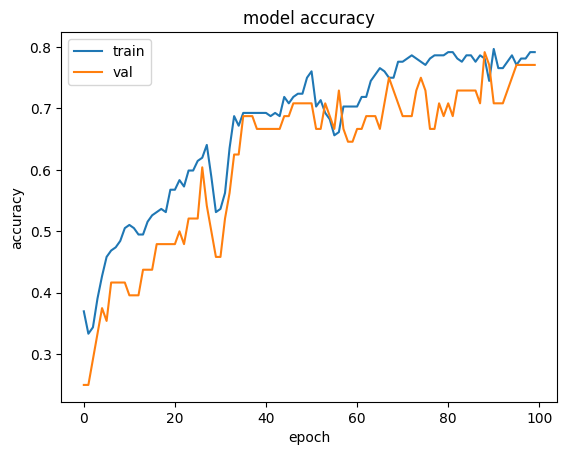

In [25]:
# accuracy 
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 17ms/step


In [27]:
cm = tf.math.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

In [28]:
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[16,  1,  1],
       [ 2, 20,  1],
       [ 9,  0, 10]], dtype=int32)>

In [29]:
model.save('./baseline_3class_7667.h5')